# Basics

## Overview
This notebook gives a basic overview of:
- Reading and writing files
- Running a simple, single DLS scan
- Running a multi-variable scan
- Basic post-processing
- Structures of the topology and results files

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MultipleLocator

%matplotlib inline

colors = ["teal", "darkorange", "firebrick", "limegreen", "magenta", "cyan", "navy"]
store_names = {
    "density": "$n_{u}\ /\ n_{u0}$",
    "power": "$q_{\parallel0}\ /\ q_{\parallel}$",
    "impurity_frac": "$f_{z}\ /\ f_{z0}$",
}

## Read V10 balance file and create topology dictionary
File is not supplied due to GitHub file size limit, contact mike.kryjak@york.ac.uk.
Below commented cell shows procedure for reading balance file for a single design and both the inner and outer divertors. Usage:

- File: path to file.
- Type: either "iu", "ou", "il" or "ol". Inner upper divertor, outer upper, inner lower, outer lower.
- Sepadd: SOL ring number. 2 means second ring from the separatrix.
- Resolution: the code interpolates SOLPS positional and B arrays onto a grid of this resolution.
- The eqb dictionary is nested as `eqb[design][side]`, where design is the STEP design and side is outer/inner/upper/lower.

If you have no balance file, you can use this pickle file (`eqb_store_lores.pkl`) which stores an example.

The example has the inner and outer upper divertors of V10, V10X and SPR38 on the 2nd SOL ring with resolution of 100 which is low. Another file is provided (`eqb_store.pkl`) with a resolution of 1000 which is more reasonable but slower to run.


In [2]:
from fusiondls import MagneticGeometry, file_read, file_write, run_dls

# Read the whole file to show whole structure
eqb = file_read("eqb_store_lores.pkl")
print(f"Designs in balance file: {list(eqb.keys())}")
print(f"Divertor legs for 'V10' design: {list(eqb['V10'].keys())}")

Designs in balance file: ['V10', 'V10X', 'SPR38']
Divertor legs for 'V10' design: ['iu', 'ou', 'il', 'ol']


### Magnetic Geometry

`fusiondls.MagneticGeometry` is a helper `dataclass` for the data in a balance file. The class method `.from_pickle` reads in a single divertor leg from the pickle balance file.

In [3]:
help(MagneticGeometry)

outer = MagneticGeometry.from_pickle("eqb_store_lores.pkl", "V10", "ou")

Help on class MagneticGeometry in module fusiondls.geometry:

class MagneticGeometry(builtins.object)
 |  MagneticGeometry(Bpol: numpy.ndarray[tuple[int, ...], numpy.dtype[numpy.floating]], Btot: numpy.ndarray[tuple[int, ...], numpy.dtype[numpy.floating]], R: numpy.ndarray[tuple[int, ...], numpy.dtype[numpy.floating]], Z: numpy.ndarray[tuple[int, ...], numpy.dtype[numpy.floating]], S: numpy.ndarray[tuple[int, ...], numpy.dtype[numpy.floating]], Spol: numpy.ndarray[tuple[int, ...], numpy.dtype[numpy.floating]], Xpoint: int, zl: numpy.ndarray[tuple[int, ...], numpy.dtype[numpy.floating]] | None = None, R_full: numpy.ndarray[tuple[int, ...], numpy.dtype[numpy.floating]] | None = None, Z_full: numpy.ndarray[tuple[int, ...], numpy.dtype[numpy.floating]] | None = None, R_ring: numpy.ndarray[tuple[int, ...], numpy.dtype[numpy.floating]] | None = None, Z_ring: numpy.ndarray[tuple[int, ...], numpy.dtype[numpy.floating]] | None = None) -> None
 |  
 |  Magnetic geometry for a diverator leg
 |  


### Visualisation of B field profile
- The DLS model cares about only two things: the total B field strength over the parallel length.
- We can plot the poloidal field or poloidal length as we wish, but only the above two variables are considered for calculation.
- It is helpful to visualise this for both the inner and outer divertor.
- Note that the outer features flux expansion (reducing Btot as the field line goes in the positive radial direction)
- And the inner features flux compression (increasing Btot as the field line goes in the negative radial direction).
- Too much flux compression can make the detachment front unstable, resulting in the DLS providing a negative relative control variable for a given position.

<Axes: xlabel='$S_{\\parallel}$ (m from target)', ylabel='$B_{tot}$ (T)'>

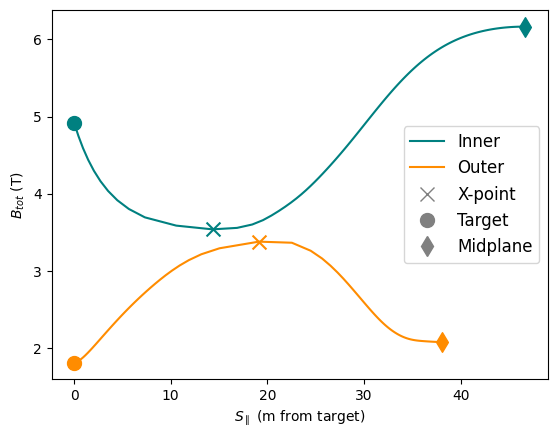

In [4]:
from fusiondls.plot import plot_B_field_profile

inner = MagneticGeometry.from_pickle("eqb_store_lores.pkl", "V10", "iu")

plot_B_field_profile(
    inner.S, inner.Btot, inner.Xpoint, outer.S, outer.Btot, outer.Xpoint
)

## Run DLS for a single scan

### DLS settings
- Default settings which may or may not be overwritten later
- Some refer to WIP features - do not use.

In [5]:
from fusiondls.AnalyticCoolingCurves import LfuncKallenbachAr

# set general run parameters
constants_default = {
    "gamma_sheath": 7,  # sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "Tt": 0.5,  # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
    "qpllu0": 1e9,  # heat flux density at the x point
    "nu": 1e20,  # Upstream density (if constant)
    "nu0": 1e20,  # Upstream density (if constant)
    "cz0": 0.02,  # Impurity fraction (if constant)
    "Lfunc": LfuncKallenbachAr,  # impurity cooling function. More are available in AnalyticCoolingCurves.py
    "upstreamGrid": True,  # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point.
}

### Run

In [6]:
# Solve at these parallel positions
SparRange = np.linspace(0, outer.S[outer.Xpoint - 1], 5)

results = run_dls(constants_default, outer, SparRange, control_variable="density")

Solving...0.00...3.76...7.52...11.29...15.05...Complete in 1.1 seconds


### Post-process

#### Structure of the results dictionary

- Splot, SpolPlot: S parallel and poloidal locations of each solved front position.
- T, S, Q, R profiles: arrays of profiles of temperature, parallel length, q parallel and radiation for each front position.
- logs: saves numerical solution history (errors, T and Q for each iteration)
- IndexRange: indices of S arrays that the front was solved at.
- cvar, crel: control variable required for each front position on absolute and relative basis.
- threshold, window: detachment threshold and window (difference of cvar at xpoint to cvar at threshold).
- window_ratio: raito of cvar at xpoint to cvar at threshold (as opposed to difference). Note that window_ratio is the variable used throughout report as "detachment window"
- spar_onset, spol_onset: first Spar/Spol where there is a stable detachment solution. Useful for inner divertors which may have unstable regions.
- constants: settings used to calculate this solution.

In [11]:
print(list(results))

['Splot', 'SpolPlot', 'cvar', 'Sprofiles', 'Tprofiles', 'Rprofiles', 'Qprofiles', 'Spolprofiles', 'Btotprofiles', 'Bpolprofiles', 'Xpoints', 'Wradials', 'logs', 'spar_onset', 'spol_onset', 'splot', 'crel', 'cvar_trim', 'crel_trim', 'threshold', 'window', 'window_frac', 'window_ratio', 'inputs', 'state']


#### Notes on post-processing
Results can be plotted on an absolute or relative basis.
- Absolute basis - cvar - Control Variable: absolute values of density, impurity frac or power.
- Relative basis - crel - Relative Control Variable: as above but normalised to value at detachment onset.
- Detachment threshold: absolute control variable (cvar) needed for front at target.
- Detachment window: relative control variable (crel) needed for front at Xpoint (equivalent to cvar_xpoint/cvar_target)
- Results can be plotted in S parallel or S poloidal: arrays SpolPlot and SparPlot .

#### Plot of single scan in density on a relative and absolute basis

[Text(0, 0.5, 'S parallel [m]'), Text(0, 0.5, 'S parallel [m]')]

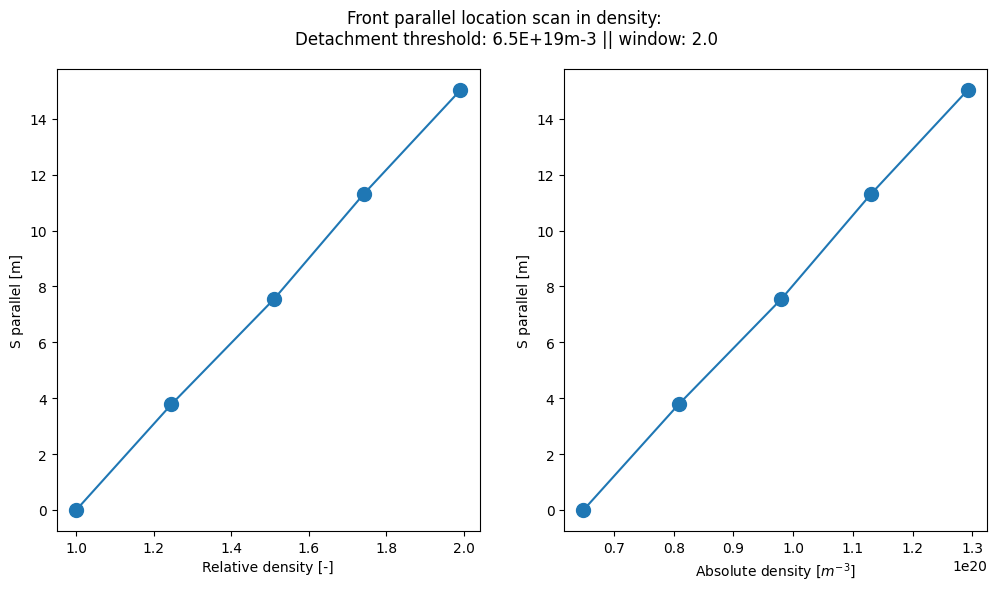

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle(
    f"Front parallel location scan in density: \nDetachment threshold: {results['threshold']:.1E}m-3 || window: {results['window_ratio']:.1f}",
    fontsize=12,
)

ax = axes[0]
ax.plot(results["crel"], results["Splot"], marker="o", ms=10)
ax.set_xlabel("Relative density [-]")

ax = axes[1]
ax.plot(results["cvar"], results["Splot"], marker="o", ms=10)
ax.set_xlabel("Absolute density [$m^{-3}$]")

[ax.set_ylabel("S parallel [m]") for ax in axes]

## Run DLS for inner and outer divertor, all variables, one STEP design
- Using same defaults as above.
- This time we are solving for 1 design, 3 variables, 2 divertor sides (outer, inner), so 2x3x1 = 6 scans.
- These are nested in for loops resulting in a nested dictionary of results.
- This code can be used to easily run cases for arbitrary number of designs, variables and divertor sides.

### Running

In [13]:
list_cvars = ["density", "power", "impurity_frac"]

example_results = {}

# For each STEP design
for design in ["V10"]:
    example_results[design] = {}
    # For each control variable
    for cvar in list_cvars:
        example_results[design][cvar] = {}
        # For inner and outer divertor
        for side, geometry in (("iu", inner), ("ou", outer)):
            print(f"Design '{design}', variable '{cvar}', side {side}:")

            constants = constants_default.copy()  # Set settings to default
            # Solve at these parallel positions
            SparRange = np.linspace(0, geometry.S[geometry.Xpoint - 1], 5)

            if side == "iu":
                # Reduce power to 10% for the inner divertor to account for power sharing
                constants["qpllu0"] = constants_default["qpllu0"] * 0.1
            example_results[design][cvar][side] = run_dls(
                constants, geometry, SparRange, verbosity=0, control_variable=cvar
            )

Design 'V10', variable 'density', side iu:
2.64...5.29...7.93...10.57...Complete in 1.4 seconds
Design 'V10', variable 'density', side ou:
3.76...7.52...11.29...15.05...Complete in 1.1 seconds
Design 'V10', variable 'power', side iu:
Solving...0.00...2.64...5.29...7.93...

/home/ltp511/workspace/FusionDLS/src/fusiondls/solver.py:734: RuntimeWarning: invalid value encountered in scalar power
  dtds = qoverB * fieldValue / (si.kappa0 * T ** (5 / 2))


10.57...Complete in 10.4 seconds
Design 'V10', variable 'power', side ou:
3.76...7.52...11.29...15.05...Complete in 2.9 seconds
Design 'V10', variable 'impurity_frac', side iu:
2.64...5.29...7.93...10.57...Complete in 1.0 seconds
Design 'V10', variable 'impurity_frac', side ou:
7.52...11.29...15.05...Complete in 1.1 seconds


### Save or read results from above cell
- Useful to do for large scans that take a long time.

In [14]:
file_write(example_results, "example_results.pkl")

In [15]:
example_results = file_read("example_results.pkl")

## Plot results on a relative basis
- Note it doesn't make much sense to plot all three variables on absolute basis in the same plot because of the differences in magnitudes.
- Note the plots indicate the region of instability caused by flux compression on the inner divertor.

Text(0.5, 1.0, 'Inner divertor')

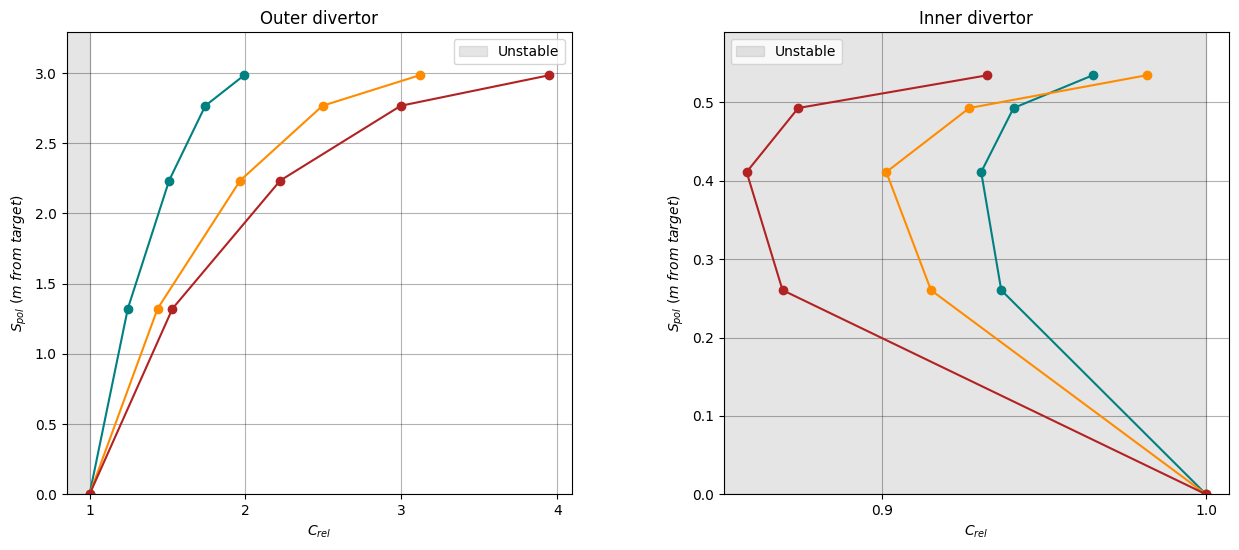

In [16]:
design = "V10"
length_basis = "SpolPlot"
variable_basis = "crel"

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
plt.subplots_adjust(hspace=0.25, wspace=0.3)

for color, cvar in zip(colors, list_cvars):
    for ax, side in zip(axes, ["ou", "iu"]):
        o = example_results[design][cvar][side]

        x = o[variable_basis]
        if cvar == "power" and variable_basis == "crel":
            x = 1 / x

        ax.plot(x, o[length_basis], marker="o", color=color)

ylims = axes[1].get_ylim()
axes[1].set_ylim(0, ylims[1])
axes[0].xaxis.set_major_locator(MultipleLocator(1))
axes[1].xaxis.set_major_locator(MultipleLocator(0.1))

for ax in axes:
    ylims = ax.get_ylim()
    xlims = ax.get_xlim()
    ylims_new = (0, ylims[1] + ylims[1] * 0.05)
    ax.set_ylim(ylims_new)
    ax.fill_between(
        [xlims[0], 1], 0, ylims_new[1], color="grey", alpha=0.2, label="Unstable"
    )
    ax.set_xlim(xlims)

    ax.grid(color="black", alpha=0.3)
    ax.set_xlabel("$C_{rel}$")
    ax.set_ylabel("$S_{pol}\ (m\ from\ target)$")
    ax.legend()

axes[0].set_title("Outer divertor")
axes[1].set_title("Inner divertor")